In [1]:
# importing required libraries 
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load the data       
test = pd.read_csv('data/test_BdBKkAj.xls')
train = pd.read_csv('data/train_aWnotuB.csv')

In [3]:
# Data information in train dataframe
def data_inf(data,name):
    print('rows: ',data.shape[0],' ,columns: ',data.shape[1],' in',name,'\n')
    data.info()
    print('\n')
data_inf(train,'Train')
display(pd.concat([train.head(5), train.tail(5)]))

rows:  48120  ,columns:  4  in Train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB




,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [4]:
# Data information in test dataframe
data_inf(test,"Test")
display(pd.concat([test.head(5), test.tail(5)]))

rows:  11808  ,columns:  3  in Test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB




,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041
11803,2017-10-31 19:00:00,4,20171031194
11804,2017-10-31 20:00:00,4,20171031204
11805,2017-10-31 21:00:00,4,20171031214
11806,2017-10-31 22:00:00,4,20171031224
11807,2017-10-31 23:00:00,4,20171031234


In [5]:
display(train.describe())
display(train.describe(include = 'object'))

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-06-30 23:00:00
freq,4


## Data processing

In [6]:
# Droping the duplicates
print('before dropping ',train.shape[0])
train.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',train.shape[0])

before dropping  48120
after dropping  48120


In [7]:
# check for missing values and fill them if there
if(train.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    train.fillna(method='ffill',inplace=True)
if(test.isnull().sum().sum()==0):
    print('no missing values in test')    
else:
    test.fillna(method='ffill',inplace=True)

no missing values in train
no missing values in test


In [8]:
# Converting datetime column into datetime ( fom string or other formats to datetime objects in pandas)
print('before converting :',train['DateTime'].dtype)
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])
print('after converting :',train['DateTime'].dtype)

before converting : object
after converting : datetime64[ns]


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


## Feature Engineering

In [10]:
# Extracting more features : the year, month, date, hour and day from the datetime column
train["Year"]= train['DateTime'].dt.year  
train["Month"]= train['DateTime'].dt.month  
train["Date_no"]= train['DateTime'].dt.day  
train["Hour"]= train['DateTime'].dt.hour  
train["Day"]= train.DateTime.dt.strftime("%A")

test["Year"]= test['DateTime'].dt.year  
test["Month"]= test['DateTime'].dt.month
test["Date_no"]= test['DateTime'].dt.day  
test["Hour"]= test['DateTime'].dt.hour 
test["Day"]= test.DateTime.dt.strftime("%A")

In [11]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [12]:
test.head()

,DateTime,Junction,ID,Year,Month,Date_no,Hour,Day
0,2017-07-01 00:00:00,1,20170701001,2017,7,1,0,Saturday
1,2017-07-01 01:00:00,1,20170701011,2017,7,1,1,Saturday
2,2017-07-01 02:00:00,1,20170701021,2017,7,1,2,Saturday
3,2017-07-01 03:00:00,1,20170701031,2017,7,1,3,Saturday
4,2017-07-01 04:00:00,1,20170701041,2017,7,1,4,Saturday


## Data Visualization 

Text(0.5, 0, 'DateTime')

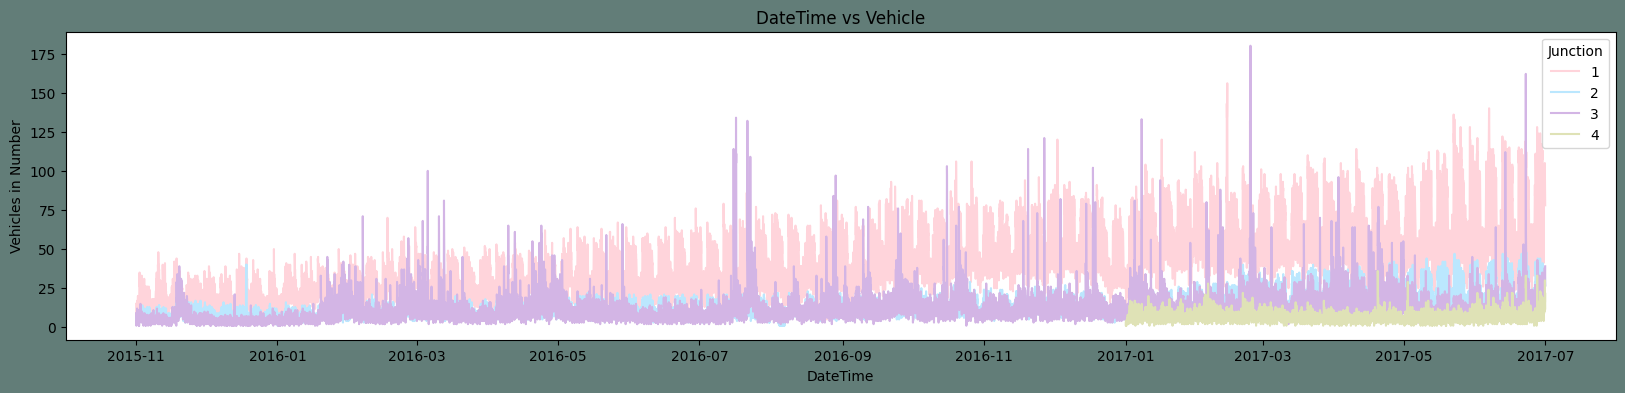

In [13]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=train['DateTime'],y="Vehicles",data=train, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime") 

Text(0.5, 0, 'Date')

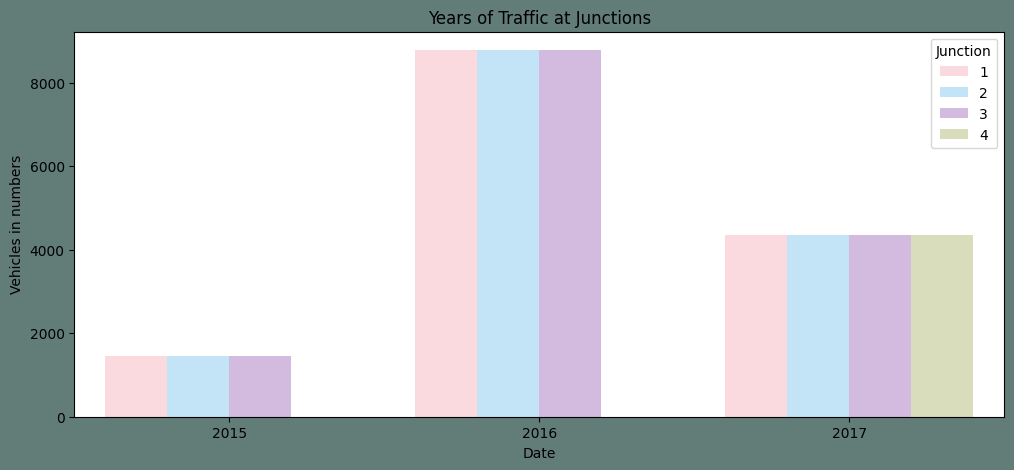

In [14]:
#years of traffic at junction
plt.figure(figsize=(12,5),facecolor="#627D78")  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
count = sns.countplot(data=train, x =train["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 

## split the train data

In [15]:
def datetounix1(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

In [16]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [17]:
train_features = datetounix1(train.drop(['Vehicles'], axis=1))
test_features = datetounix1(test)


# Store Features / Predictors in array :
X = train_features  
X_valid = test_features

# One Hot Encoding - Using Dummies :
X = pd.get_dummies(X)
X_valid = pd.get_dummies(X_valid)

# Store target 'Vehicles' in y array :
y = train['Vehicles'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=512)

# LGBM Regression

In [18]:
# Convert the dataset to LightGBM data format
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for the LightGBM regression model
params = {
    'objective': 'regression',
    'metric': 'rmse'  # Root Mean Squared Error
}

# Train the LightGBM regression model
model = lgb.train(params,train_data, num_boost_round=100)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 33684, number of used features: 14
[LightGBM] [Info] Start training from score 22.686884
Mean Squared Error: 25.178448310366488
Mean Absolute Error: 2.9260457783668548
R2 Score: 0.9428530897968173


# Random Forest regressor

In [19]:
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

/Users/meriemdahmani/.pyenv/versions/3.12.2/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [20]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 15.195894555278471
Mean Absolute Error: 2.4882571349404263
R2 Score: 0.9655102486498346


## ARIMA

Mean Squared Error (MSE): 100.68079950269552
Mean Absolute Error (MAE): 6.431421940105848
Root Mean Squared Error (RMSE): 10.033982235518236
R2 Score: -0.013446314657667324


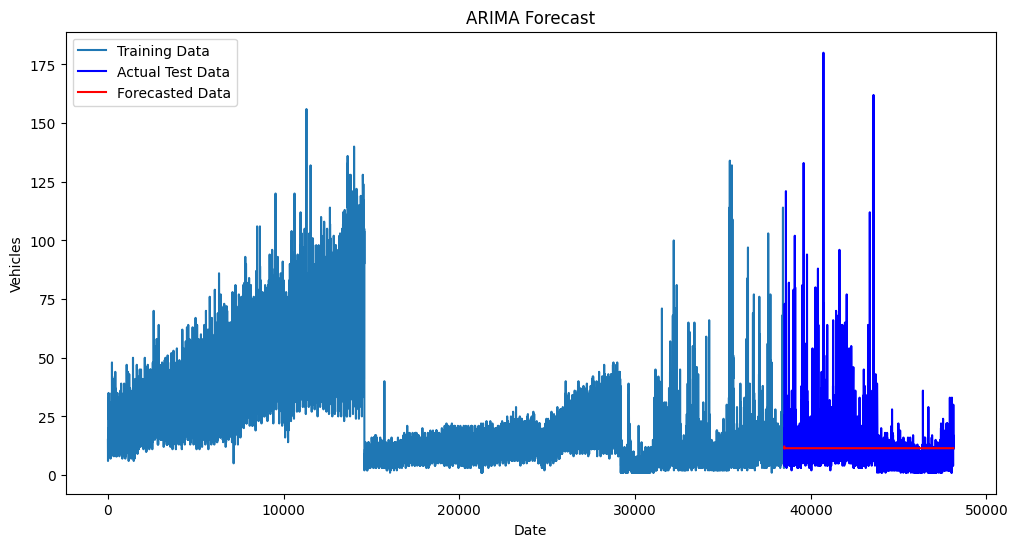

In [21]:
# Extract the target variable from the data
target = train[['Vehicles']] 

# Split the data into training and testing sets
train_data, test_data = train_test_split(target, test_size=0.2, shuffle=False)  # Use 20% of data for testing

# Define and fit the ARIMA model
model = ARIMA(train_data, order=(5,1,0))  # Example order; adjust (p,d,q) as needed
model_fit = model.fit()  # Fit the model

# Forecast future values based on the test set length
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Evaluate the model
actual_values = test_data['Vehicles']
mse = mean_squared_error(actual_values, forecast)
mae = mean_absolute_error(actual_values, forecast)
r2 = r2_score(actual_values, forecast)
rmse = mse**0.5

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Vehicles'], label='Training Data')
plt.plot(test_data.index, actual_values, label='Actual Test Data', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()
